In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv


In [16]:
sales_data = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
calendar= pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
price = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')


In [17]:
sales_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [10]:
price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [11]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [18]:
sales_data.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1919)

In [19]:


categories = sales_data[['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]
sales_data['id'] = sales_data['id'].apply(lambda x: x[:-11])
ids = sales_data['id'].values


    # Only last 360 days are used to save run time
sales_data = sales_data.iloc[:, -360:].T.reset_index()    
sales_data.columns = ['d'] + list(ids)

In [21]:
sales_data.head()

,d,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,...,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
0,d_1554,1,0,0,1,2,3,1,1,0,...,2,2,1,3,1,0,0,0,0,0
1,d_1555,1,0,1,6,3,2,0,6,2,...,0,4,2,0,4,0,0,2,0,5
2,d_1556,2,1,0,7,4,1,0,20,0,...,2,3,1,2,3,0,0,1,0,10
3,d_1557,0,0,0,0,2,0,0,9,0,...,7,0,0,0,2,0,0,3,0,5
4,d_1558,0,1,1,2,0,0,0,13,1,...,1,0,1,0,4,1,0,0,0,5


In [23]:
calendar = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv',
                       dtype={'wm_yr_wk': np.int32, 'wday': np.int32, 
                              'month': np.int32, 'year': np.int32, 
                              'snap_CA': np.int32, 'snap_TX': np.int32,
                              'snap_WI': np.int32})

# only the last 360 days
calendar = calendar[calendar.d.apply(lambda x: int(x[2:])) >= int(sales_data.d[0][2:])]

In [25]:
prices = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv',
                          dtype={'wm_yr_wk': np.int32, 
                                 'sell_price': np.float32})
prices = prices.loc[prices.wm_yr_wk >= \
                    calendar[calendar.d == sales_data.d[0]]['wm_yr_wk'].values[0]]

prices['id'] = prices.apply(lambda x: x.item_id + '_' + x.store_id, axis=1)
prices = prices.pivot(index='wm_yr_wk', columns='id', values='sell_price')

prices = calendar[['d','wm_yr_wk']].merge(prices, how='inner', on=['wm_yr_wk'])
prices.drop('wm_yr_wk', axis=1, inplace=True)
prices = prices.loc[:, list(sales_data.columns)]

calendar.drop(['date','wm_yr_wk', 'weekday', 'd'], axis=1, inplace=True)


In [26]:
calendar.head()

,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1553,7,5,2015,NaN,NaN,NaN,NaN,1,1,0
1554,1,5,2015,NaN,NaN,NaN,NaN,1,0,1
1555,2,5,2015,NaN,NaN,NaN,NaN,1,1,1
1556,3,5,2015,NaN,NaN,NaN,NaN,1,0,0
1557,4,5,2015,Cinco De Mayo,Cultural,NaN,NaN,1,1,1


In [27]:
prices.head()

,d,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,...,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
0,d_1554,8.26,3.97,2.97,4.64,2.88,1.0,7.88,0.48,1.77,...,2.98,1.98,1.98,4.98,4.28,2.88,2.0,3.98,1.28,1.0
1,d_1555,8.26,3.97,2.97,4.64,2.88,1.0,7.88,0.48,1.77,...,2.98,1.98,1.98,4.98,4.28,2.88,2.0,3.98,1.28,1.0
2,d_1556,8.26,3.97,2.97,4.64,2.88,1.0,7.88,0.48,1.77,...,2.98,1.98,1.98,4.98,4.28,2.88,2.0,3.98,1.28,1.0
3,d_1557,8.26,3.97,2.97,4.64,2.88,1.0,7.88,0.48,1.77,...,2.98,1.98,1.98,4.98,4.28,2.88,2.0,3.98,1.28,1.0
4,d_1558,8.26,3.97,2.97,4.64,2.88,1.0,7.88,0.48,1.77,...,2.98,1.98,1.98,4.98,4.28,2.88,2.0,3.98,1.28,1.0


In [44]:
sales_data=sales_data.T.reset_index()

In [46]:
dataset=sales_data[sales_data['index']!='d']
dataset.head()


,index,0,1,2,3,4,5,6,7,8,...,350,351,352,353,354,355,356,357,358,359
1,HOBBIES_1_001_CA_1,1,1,2,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
2,HOBBIES_1_002_CA_1,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,HOBBIES_1_003_CA_1,0,1,0,0,1,0,0,0,1,...,2,1,2,1,1,1,0,1,1,1
4,HOBBIES_1_004_CA_1,1,6,7,0,2,1,0,3,8,...,1,0,5,4,1,0,1,3,7,2
5,HOBBIES_1_005_CA_1,2,3,4,2,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [57]:
dataset=dataset.drop(['index'],axis=1)

In [58]:
# X we will keep all columns execpt the last two(0 to 357)
X_train = np.expand_dims(dataset.values[:,:-2],axis = 2)

# the last columns are our target (358,359)
y_train = dataset.values[:,-2:]

# for test we keep all the columns execpt the first two
X_test = np.expand_dims(dataset.values[:,2:],axis = 2)

# lets check the shape 
print(X_train.shape,y_train.shape,X_test.shape)

(30490, 358, 1) (30490, 2) (30490, 358, 1)


In [59]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout

In [62]:
my_model = Sequential()
my_model.add(LSTM(units = 64,input_shape = (358,1)))
my_model.add(Dropout(0.4))
my_model.add(Dense(2))

my_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
my_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 17,026
Trainable params: 17,026
Non-trainable params: 0
_________________________________________________________________


In [63]:
hist=my_model.fit(X_train,y_train,batch_size = 4096,epochs = 10)

Epoch 1/10
30490/30490 [==============================] - 56s 2ms/step - loss: 17.4484 - mean_squared_error: 17.4484
Epoch 2/10
30490/30490 [==============================] - 50s 2ms/step - loss: 15.5558 - mean_squared_error: 15.5558
Epoch 3/10
30490/30490 [==============================] - 53s 2ms/step - loss: 14.3039 - mean_squared_error: 14.3039
Epoch 4/10
30490/30490 [==============================] - 52s 2ms/step - loss: 13.3547 - mean_squared_error: 13.3547
Epoch 5/10
30490/30490 [==============================] - 51s 2ms/step - loss: 12.6367 - mean_squared_error: 12.6367
Epoch 6/10
30490/30490 [==============================] - 61s 2ms/step - loss: 11.9692 - mean_squared_error: 11.9692
Epoch 7/10
30490/30490 [==============================] - 51s 2ms/step - loss: 11.4573 - mean_squared_error: 11.4573
Epoch 8/10
30490/30490 [==============================] - 51s 2ms/step - loss: 10.9247 - mean_squared_error: 10.9247
Epoch 9/10
30490/30490 [==============================] - 50s 2m

In [64]:
submission_pfs = my_model.predict(X_test)

In [89]:
res=pd.DataFrame(submission_pfs)
res.columns=['pred1','pred2']
res['pred1']=np.round(res['pred1'])
res['pred2']=np.round(res['pred2'])
res.head()

,pred1,pred2
0,1.0,1.0
1,0.0,0.0
2,1.0,1.0
3,3.0,3.0
4,2.0,2.0


In [90]:
res.shape

(30490, 2)

In [91]:
select=sales_data[['index',358,359]]
select=select[select['index']!='d'].reset_index()
select.shape

(30490, 4)

In [92]:
select.head()

,level_0,index,358,359
0,1,HOBBIES_1_001_CA_1,1,1
1,2,HOBBIES_1_002_CA_1,0,0
2,3,HOBBIES_1_003_CA_1,1,1
3,4,HOBBIES_1_004_CA_1,7,2
4,5,HOBBIES_1_005_CA_1,2,4


In [93]:
final=pd.concat([select,res],axis=1)

In [98]:
final.head()
final[358]=final[358].astype(int)
final[359]=final[359].astype(int)

In [100]:
final['1_stp_err']=abs(final[358]-final['pred1'])
final['2_stp_err']=abs(final[359]-final['pred2'])

In [101]:
final.describe()

,level_0,358,359,pred1,pred2,1_stp_err,2_stp_err
count,30490.00000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,15245.50000,1.605838,1.633158,1.372811,1.356510,0.993342,1.044638
std,8801.84919,4.089422,3.812248,1.882577,1.748008,2.987088,2.755965
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7623.25000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15245.50000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,22867.75000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000
max,30490.00000,171.000000,130.000000,9.000000,7.000000,164.000000,124.000000


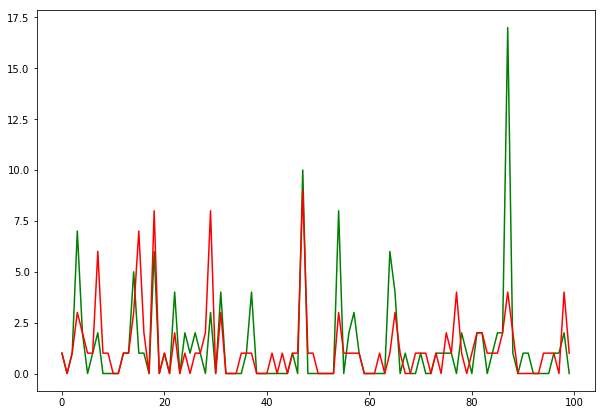

In [104]:
# lets plot the actuals vs predicted for the top 100 item-store pairs, for the 1st time step 
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(final[358].head(100),color='g')
plt.plot(final['pred1'].head(100),color='r')

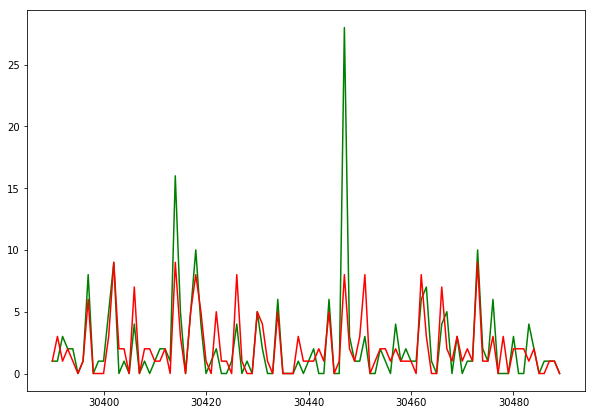

In [105]:
# lets plot the actuals vs predicted for the last 100 item-store pairs, for the 1st time step 
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(final[358].tail(100),color='g')
plt.plot(final['pred1'].tail(100),color='r')

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(final[359].head(100),color='g')
plt.plot(final['pred2'].head(100),color='r')

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(final[359].tail(100),color='g')
plt.plot(final['pred2'].tail(100),color='r')